In [263]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import matplotlib.pyplot as plt
import torch

import torch.nn as nn
from torch.nn import Linear
from torch.utils.data.sampler import SubsetRandomSampler

from torch_geometric.utils import scatter
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_geometric.loader import DataLoader

#Device Agnostic code
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

dataset = torch.load("D:\\cleaned_graph_data_electron.pt")

In [264]:
dataset[1]

Data(x=[28, 6], edge_index=[2, 27], edge_attr=[27, 2], y=260.23077392578125)

In [266]:

class MPNNLayer(MessagePassing):
    def __init__(self, emb_dim , hidden_layers , edge_dim, aggr='add'):   #(64, 32, 1)
        super().__init__(aggr=aggr)

        self.emb_dim = emb_dim      #64
        self.edge_dim = edge_dim    #1
        
        self.mlp_msg = nn.Sequential(
            Linear(2 * emb_dim + edge_dim, hidden_layers), nn.BatchNorm1d(hidden_layers), nn.ReLU(),nn.Dropout(0.5),
            Linear(hidden_layers, emb_dim), nn.ReLU(),nn.Dropout(0.5), nn.BatchNorm1d(emb_dim)
        )    #(E, 64)

        self.upd_msg = nn.Sequential(
            Linear(emb_dim * 2, hidden_layers), nn.BatchNorm1d(hidden_layers), nn.ReLU(),
            Linear(hidden_layers, emb_dim), nn.ReLU(), nn.BatchNorm1d(emb_dim)
        )   #(N, 64)

    def forward(self, x, edge_index, edge_attr):
        self.x = x  #[N,25]
        return self.propagate(edge_index=edge_index, x=x, edge_attr=edge_attr, size=(x.size(0), x.size(0)))

        #x_i contains the features of the target nodes for each edge
        #x_j contains the features of the source nodes for each edge
    def message(self, x_i, x_j, edge_attr):
        msg_input = torch.cat([x_i, x_j, edge_attr], dim=1)     #(E, 3)
        return self.mlp_msg(msg_input)                          #(E, 64)

        #inputs = the output of message
        #index is x_i
    def aggregate(self, inputs, index):
        return scatter(inputs, index, dim=0, reduce=self.aggr, dim_size=self.x.size(0))  #(N, 64)

        #aggr_out is the output of aggregate (N,64)
        #x is original node features (N, 64)
    def update(self, aggr_out, x):
        upd_input = torch.cat([x, aggr_out], dim=1)
        
        return  self.upd_msg(upd_input) #(N, 64)


class MPNNModel(nn.Module):
    def __init__(self, in_dim, edge_dim, hidden_dim=64, num_layers=5): #(25,1)
        super().__init__()

        #1.
        self.lin_in = nn.Linear(in_dim, hidden_dim)
                                  #x --> (N, 64) 
        #2. layers of calling
        self.convs = nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(MPNNLayer(emb_dim = hidden_dim ,hidden_layers =32, edge_dim = edge_dim))
                                        # emb_dim = 64                              edge_dim = 1                 
          
        #3.Pooling
        self.pool = global_mean_pool #[1,64]
        
        #4. Linear
        self.lin_layer = nn.Sequential(
                                nn.Linear(hidden_dim, 1),
                                )

    
    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        x =self.lin_in(x) #(N, 64)
        #print("BEFORE CONV: ", x.shape)
        for conv in self.convs:
    
            x += conv(x, edge_index, edge_attr)   

        x = self.pool(x, batch) 

        return self.lin_layer(x).view(-1)

In [ ]:

#Creating training and testing datasets
batch_size = 32
test_size = 0.1
num_samples = len(dataset)

test_no = int(test_size * num_samples)
valid_no = test_no

train_no = len(dataset) - test_no*2

np.random.seed(42)
indices = len(dataset)
np.random.shuffle(indices)
train_index, test_index, valid_index = indices[:train_no], indices[train_no:train_no+test_no], indices[train_no+test_no:train_no+test_no+valid_no]

# define samplers for obtaining training and testing batches
train_sampler = SubsetRandomSampler(train_index)
test_sampler = SubsetRandomSampler(test_index)
valid_sampler = SubsetRandomSampler(valid_index)

train_load = DataLoader(dataset, batch_size = batch_size, sampler = train_sampler)
test_load = DataLoader(dataset, batch_size = batch_size, sampler = test_sampler)
valid_load = DataLoader(dataset, batch_size = batch_size, sampler = valid_sampler)


SyntaxError: unexpected character after line continuation character (2000306102.py, line 12)

In [ ]:
for i in test_load:
    print(lens(i).batch)
    break

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  8,  8,  8, 

In [290]:

model_test = MPNNModel(in_dim= len(dataset[0].x[0]), edge_dim=len(dataset[0].edge_attr[0])).to(device)
model_test.load_state_dict(torch.load('model_regress.pt', weights_only=True))
model_test.to(device)

def valid(valid_loader, model):
    model_test.eval()
    valid_pred_per_event = []
    valid_true_per_event = []

    with torch.inference_mode():
        for data in valid_loader:
            data = data.to(device)

            valid_pred_per_event.append(model(data))
            valid_true_per_event.append(data.y)

    return valid_pred_per_event , valid_true_per_event   

tensor_pred, tensor_true  = valid(valid_load, model_test)
flat_list_pred = [item.item() for tensor in tensor_pred for item in tensor]
flat_list_true = [item.item() for tensor in tensor_true for item in tensor]

plt.figure(figsize=(12,4))
plt.plot(np.arange(50), flat_list_pred[:50], color="purple", label="Predicted energies")
plt.plot( np.arange(50),flat_list_true[:50], color="blue", label="True energies")
plt.title("Energy prediction plot")
plt.xlabel("Event no.")
plt.ylabel("Energy(GeV)")
plt.legend()
plt.grid(True)
plt.show()




RuntimeError: Error(s) in loading state_dict for MPNNModel:
	Missing key(s) in state_dict: "lin_in.weight", "lin_in.bias", "convs.0.mlp_msg.0.weight", "convs.0.mlp_msg.0.bias", "convs.0.mlp_msg.1.weight", "convs.0.mlp_msg.1.bias", "convs.0.mlp_msg.1.running_mean", "convs.0.mlp_msg.1.running_var", "convs.0.mlp_msg.4.weight", "convs.0.mlp_msg.4.bias", "convs.0.mlp_msg.7.weight", "convs.0.mlp_msg.7.bias", "convs.0.mlp_msg.7.running_mean", "convs.0.mlp_msg.7.running_var", "convs.0.upd_msg.0.weight", "convs.0.upd_msg.0.bias", "convs.0.upd_msg.1.weight", "convs.0.upd_msg.1.bias", "convs.0.upd_msg.1.running_mean", "convs.0.upd_msg.1.running_var", "convs.0.upd_msg.3.weight", "convs.0.upd_msg.3.bias", "convs.0.upd_msg.5.weight", "convs.0.upd_msg.5.bias", "convs.0.upd_msg.5.running_mean", "convs.0.upd_msg.5.running_var", "convs.1.mlp_msg.0.weight", "convs.1.mlp_msg.0.bias", "convs.1.mlp_msg.1.weight", "convs.1.mlp_msg.1.bias", "convs.1.mlp_msg.1.running_mean", "convs.1.mlp_msg.1.running_var", "convs.1.mlp_msg.4.weight", "convs.1.mlp_msg.4.bias", "convs.1.mlp_msg.7.weight", "convs.1.mlp_msg.7.bias", "convs.1.mlp_msg.7.running_mean", "convs.1.mlp_msg.7.running_var", "convs.1.upd_msg.0.weight", "convs.1.upd_msg.0.bias", "convs.1.upd_msg.1.weight", "convs.1.upd_msg.1.bias", "convs.1.upd_msg.1.running_mean", "convs.1.upd_msg.1.running_var", "convs.1.upd_msg.3.weight", "convs.1.upd_msg.3.bias", "convs.1.upd_msg.5.weight", "convs.1.upd_msg.5.bias", "convs.1.upd_msg.5.running_mean", "convs.1.upd_msg.5.running_var", "convs.2.mlp_msg.0.weight", "convs.2.mlp_msg.0.bias", "convs.2.mlp_msg.1.weight", "convs.2.mlp_msg.1.bias", "convs.2.mlp_msg.1.running_mean", "convs.2.mlp_msg.1.running_var", "convs.2.mlp_msg.4.weight", "convs.2.mlp_msg.4.bias", "convs.2.mlp_msg.7.weight", "convs.2.mlp_msg.7.bias", "convs.2.mlp_msg.7.running_mean", "convs.2.mlp_msg.7.running_var", "convs.2.upd_msg.0.weight", "convs.2.upd_msg.0.bias", "convs.2.upd_msg.1.weight", "convs.2.upd_msg.1.bias", "convs.2.upd_msg.1.running_mean", "convs.2.upd_msg.1.running_var", "convs.2.upd_msg.3.weight", "convs.2.upd_msg.3.bias", "convs.2.upd_msg.5.weight", "convs.2.upd_msg.5.bias", "convs.2.upd_msg.5.running_mean", "convs.2.upd_msg.5.running_var", "convs.3.mlp_msg.0.weight", "convs.3.mlp_msg.0.bias", "convs.3.mlp_msg.1.weight", "convs.3.mlp_msg.1.bias", "convs.3.mlp_msg.1.running_mean", "convs.3.mlp_msg.1.running_var", "convs.3.mlp_msg.4.weight", "convs.3.mlp_msg.4.bias", "convs.3.mlp_msg.7.weight", "convs.3.mlp_msg.7.bias", "convs.3.mlp_msg.7.running_mean", "convs.3.mlp_msg.7.running_var", "convs.3.upd_msg.0.weight", "convs.3.upd_msg.0.bias", "convs.3.upd_msg.1.weight", "convs.3.upd_msg.1.bias", "convs.3.upd_msg.1.running_mean", "convs.3.upd_msg.1.running_var", "convs.3.upd_msg.3.weight", "convs.3.upd_msg.3.bias", "convs.3.upd_msg.5.weight", "convs.3.upd_msg.5.bias", "convs.3.upd_msg.5.running_mean", "convs.3.upd_msg.5.running_var", "convs.4.mlp_msg.0.weight", "convs.4.mlp_msg.0.bias", "convs.4.mlp_msg.1.weight", "convs.4.mlp_msg.1.bias", "convs.4.mlp_msg.1.running_mean", "convs.4.mlp_msg.1.running_var", "convs.4.mlp_msg.4.weight", "convs.4.mlp_msg.4.bias", "convs.4.mlp_msg.7.weight", "convs.4.mlp_msg.7.bias", "convs.4.mlp_msg.7.running_mean", "convs.4.mlp_msg.7.running_var", "convs.4.upd_msg.0.weight", "convs.4.upd_msg.0.bias", "convs.4.upd_msg.1.weight", "convs.4.upd_msg.1.bias", "convs.4.upd_msg.1.running_mean", "convs.4.upd_msg.1.running_var", "convs.4.upd_msg.3.weight", "convs.4.upd_msg.3.bias", "convs.4.upd_msg.5.weight", "convs.4.upd_msg.5.bias", "convs.4.upd_msg.5.running_mean", "convs.4.upd_msg.5.running_var", "lin_layer.0.weight", "lin_layer.0.bias". 
	Unexpected key(s) in state_dict: "conv1.bias", "conv1.lin.weight", "conv2.bias", "conv2.lin.weight", "conv3.bias", "conv3.lin.weight", "lin.weight", "lin.bias". 

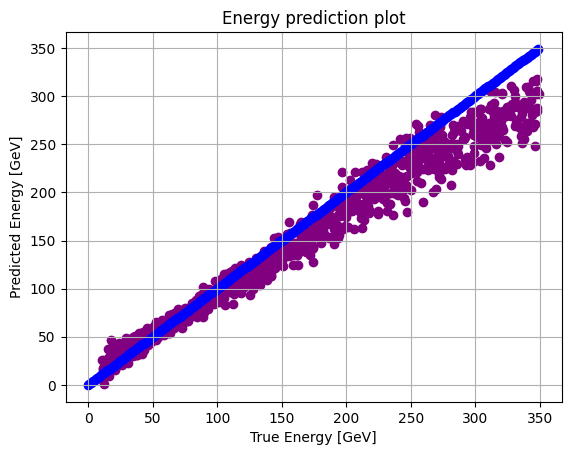

In [270]:
plt.scatter(flat_list_true[:1000], flat_list_pred[:1000], color="purple")
y = np.max(np.array(flat_list_true[:1000]))
plt.scatter(np.arange(y), np.arange(y), color="blue")
plt.title("Energy prediction plot")
plt.xlabel("True Energy [GeV]")
plt.ylabel("Predicted Energy [GeV]")

plt.grid(True)
plt.show()



In [271]:
from scipy.stats import norm

import matplotlib.pyplot as plt

def plot_gaussian_fit(ax, preds, bin_range, color='blue', alpha=0.5, density=True):
    # Histogram
    counts, bins, _ = ax.hist(preds, bins=30, density=density, alpha=alpha,
                              color=color, edgecolor='black')

    # Fit Gaussian
    mu, std = norm.fit(preds)
    mu_err = std / np.sqrt(len(preds))
    std_err = std / np.sqrt(2 * len(preds))

    # Plot Gaussian curve
    x = np.linspace(bins[0], bins[-1], 1000)
    p = norm.pdf(x, mu, std)
    ax.plot(x, p, 'k', linewidth=2)

    # Title with bin and stats
    ax.set_title(
        f"{bin_range[0]}–{bin_range[1]} GeV\n"
        rf"$\mu = {mu:.2f} \pm {mu_err:.2f}$, "
        rf"$\sigma = {std:.2f} \pm {std_err:.2f}$",
        fontsize=10
    )

    res_vals = std/mu
    res_err = std/mu * np.sqrt((mu_err/mu)**2 + (std_err/std)**2)
    res_errs = res_err

    return res_vals, res_errs

In [ ]:
import h5py

In [ ]:
file = "C:\\Users\\SAWINI JANA\\Downloads\\Compressed\\hgcal_electron_data_0001.h5\\hgcal_electron_data_0001.h5"

In [272]:
len(flat_list_pred)
len(flat_list_true)

5000

In [273]:
arr = np.linspace(90, 180, 10, dtype=int)
print(arr[::3])
print(arr)

[ 90 120 150 180]
[ 90 100 110 120 130 140 150 160 170 180]


In [274]:
flat_list_true

[133.50839233398438,
 48.644527435302734,
 89.41705322265625,
 248.5035400390625,
 216.93743896484375,
 180.0883331298828,
 199.7760467529297,
 342.34381103515625,
 265.716064453125,
 23.296232223510742,
 257.7359619140625,
 141.92970275878906,
 318.6556701660156,
 291.7213134765625,
 280.9249267578125,
 74.18582916259766,
 313.82403564453125,
 270.9696044921875,
 154.5474090576172,
 109.73754119873047,
 267.2616271972656,
 264.4653625488281,
 274.0935363769531,
 307.0911560058594,
 146.80479431152344,
 331.9893798828125,
 237.18777465820312,
 216.12525939941406,
 18.278549194335938,
 83.94652557373047,
 35.52638626098633,
 87.11354064941406,
 231.99600219726562,
 174.3033905029297,
 169.49996948242188,
 292.2006530761719,
 81.14452362060547,
 19.290843963623047,
 231.26560974121094,
 47.54278564453125,
 178.208251953125,
 222.2545928955078,
 221.14527893066406,
 271.4881286621094,
 201.53016662597656,
 98.6279525756836,
 340.6851501464844,
 92.1202621459961,
 347.3727722167969,
 108.1

In [275]:
c,b = np.histogram(flat_list_true, bins = np.arange(0,400,30))

In [276]:
bin_centers = np.diff(b)

In [277]:
bin_cents = np.array([(b[i] + b[i+1])/2 for i in range(len(b)-1)])

In [278]:
bin_cents

array([ 15.,  45.,  75., 105., 135., 165., 195., 225., 255., 285., 315.,
       345., 375.])

In [279]:
bin_cents[3:-3].shape

(7,)

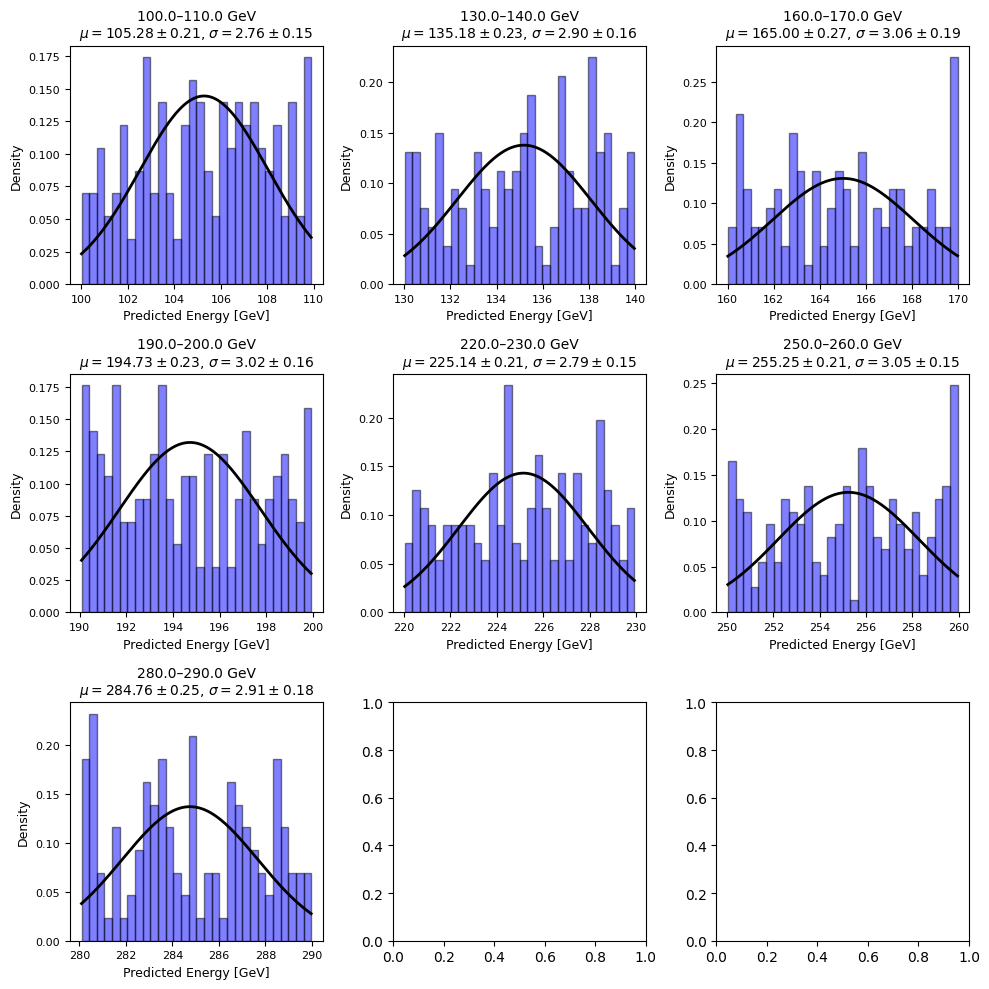

In [283]:
# Convert lists to arrays
flat_list_pred = np.array(flat_list_pred)
flat_list_true = np.array(flat_list_true)

# Bin edges
c,b = np.histogram(flat_list_true, bins = np.arange(0,400,30))

bin_cents = np.array([(b[i] + b[i+1])/2 for i in range(len(b)-1)])[3:-3]

# #arr = arr[::3]
# print(len(arr))
# print(arr)
# Create 3x3 subplots
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()
res_val = []
res_err = []

delta = 5
for ax,c_bin in zip(axes,bin_cents):
    mask = (flat_list_pred >  c_bin - delta) & (flat_list_pred < c_bin + delta)
    preds_in_bin = flat_list_pred[mask]
    #print(preds_in_bin)


    if len(preds_in_bin) > 0:
        res_vals , res_errs = plot_gaussian_fit(ax, preds_in_bin, bin_range=(c_bin - delta, c_bin + delta), color='blue', alpha=0.5)
        res_val.append(res_vals)
        res_err.append(res_errs)
    else:
        ax.set_visible(False)


    ax.set_xlabel("Predicted Energy [GeV]", fontsize=9)
    ax.set_ylabel("Density", fontsize=9)
    ax.tick_params(axis='both', labelsize=8)

plt.tight_layout()
plt.show()






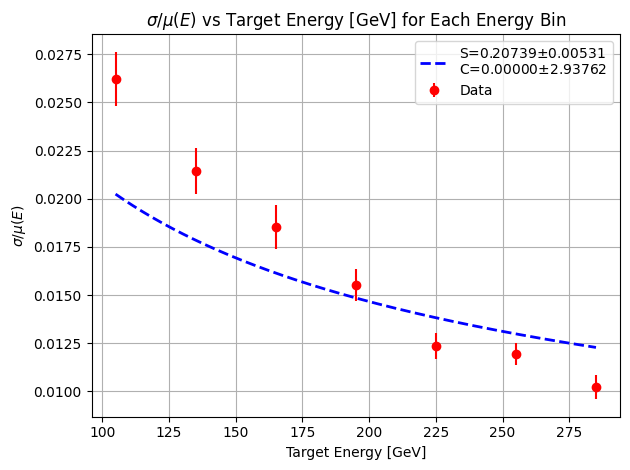

In [284]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Example data (replace with your actual values)
E_bin_centers = bin_cents
res_vals = res_val
res_errs = res_err

# Define the resolution model: σ/μ = sqrt( (S/√E)^2 + C^2 )
def resolution(E, S, C):
    return np.sqrt((S / np.sqrt(E))**2 + C**2)

# Fit the function to data
popt, pcov = curve_fit(resolution, E_bin_centers, np.array(res_vals), sigma=res_errs, absolute_sigma=True)
S_fit, C_fit = popt
S_err, C_err = np.sqrt(np.diag(pcov))

# Plot
plt.errorbar(E_bin_centers, res_vals, yerr=res_errs, fmt='o', color='red', label='Data')
E_fit = np.linspace(min(E_bin_centers), max(E_bin_centers), 500)
plt.plot(E_fit, resolution(E_fit, *popt), 'b--', linewidth=2, 
         label=f'S={S_fit:.5f}'+ r'$\pm$'+ f'{S_err:.5f}' + '\n' + f'C={C_fit:.5f}' + r'$\pm$' + f'{C_err:.5f}')

# Labels and Title
plt.xlabel("Target Energy [GeV]")
plt.ylabel(r"$\sigma / \mu(E)$")
plt.title(r"$\sigma / \mu(E)$ vs Target Energy [GeV] for Each Energy Bin")
plt.legend(fontsize=10, loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
bin_cents, res_vals

(array([ 15., 105., 195., 285., 375.]),
 [np.float64(0.0),
  np.float64(0.026179183048057324),
  np.float64(0.014015030899185188),
  np.float64(0.010714235875420143)])

In [287]:
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_geometric.utils import add_self_loops, degree, scatter, index_to_mask

class GCNConv(MessagePassing):

    def __init__(self, in_channels, out_channels):
        super().__init__(aggr="add")
        self.lin = Linear(in_channels, out_channels, bias =False)
        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()
    
    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()

    def forward(self, x, edge_index, batch):
        #x --> [N, in_channels]
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0)) #2,E
        
        x = self.lin(x) # x --> [N, out_channels]

        source, target = edge_index #[E]
        #print(f"HI: {len(target)}")
        deg = degree(target, x.size(0), dtype=x.dtype) #[N]
        deg_inv_sqrt = deg.pow(-0.5) #[N]
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[source] * deg_inv_sqrt[target] #[E]
        #print(f"HI: {norm.shape}")
        out = self.propagate(edge_index, x=x, norm=norm)
        #[N, out_channels]
        #but why change from E to N? 

        out = out + self.bias
        
        return out

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j
           #*[E,1] x [E, out_channels] = [E, out_channels] 


class GCNModule(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.conv1 = GCNConv(in_dim,hidden_dim)
        self.conv2 = GCNConv(hidden_dim, 2*hidden_dim)
        self.conv3 = GCNConv(2*hidden_dim, hidden_dim)
        self.lin = nn.Linear(hidden_dim, out_dim)

    def forward(self, x, edge_index, batch):
        #print("x:", x.shape)
        x = self.conv1(x, edge_index, batch)
        #print("After conv1:", x.shape)
        x = F.relu(x)
        x = self.conv2(x, edge_index, batch)
        #print("After conv2:", x.shape)
        x = F.relu(x)
        x = self.conv3(x, edge_index, batch)
        x = F.relu(x)

        x = global_mean_pool(x, batch)
        #print("After global mean pool:", x.shape)
        
        return self.lin(x)

model = GCNModule(in_dim= len(dataset[0].x[0]),hidden_dim = 64, out_dim = 1)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
loss = nn.MSELoss()


In [289]:
model_test = MPNNModel(in_dim= len(dataset[0].x[0]), edge_dim=len(dataset[0].edge_attr[0]) ).to(device)
model_test.load_state_dict(torch.load('model_regress.pt', weights_only=True))
model_test.to(device)

def valid(valid_loader, model):
    model_test.eval()
    valid_pred_per_event = []
    valid_true_per_event = []

    with torch.inference_mode():
        for data in valid_loader:
            data = data.to(device)

            valid_pred_per_event.append(model(data))
            valid_true_per_event.append(data.y)

    return valid_pred_per_event , valid_true_per_event   

tensor_pred, tensor_true  = valid(valid_load, model_test)
flat_list_pred = [item.item() for tensor in tensor_pred for item in tensor]
flat_list_true = [item.item() for tensor in tensor_true for item in tensor]

plt.figure(figsize=(12,4))
plt.plot(np.arange(50), flat_list_pred[:50], color="purple", label="Predicted energies")
plt.plot( np.arange(50),flat_list_true[:50], color="blue", label="True energies")
plt.title("Energy prediction plot")
plt.xlabel("Event no.")
plt.ylabel("Energy(GeV)")
plt.legend()
plt.grid(True)
plt.show()



RuntimeError: Error(s) in loading state_dict for MPNNModel:
	Missing key(s) in state_dict: "lin_in.weight", "lin_in.bias", "convs.0.mlp_msg.0.weight", "convs.0.mlp_msg.0.bias", "convs.0.mlp_msg.1.weight", "convs.0.mlp_msg.1.bias", "convs.0.mlp_msg.1.running_mean", "convs.0.mlp_msg.1.running_var", "convs.0.mlp_msg.4.weight", "convs.0.mlp_msg.4.bias", "convs.0.mlp_msg.7.weight", "convs.0.mlp_msg.7.bias", "convs.0.mlp_msg.7.running_mean", "convs.0.mlp_msg.7.running_var", "convs.0.upd_msg.0.weight", "convs.0.upd_msg.0.bias", "convs.0.upd_msg.1.weight", "convs.0.upd_msg.1.bias", "convs.0.upd_msg.1.running_mean", "convs.0.upd_msg.1.running_var", "convs.0.upd_msg.3.weight", "convs.0.upd_msg.3.bias", "convs.0.upd_msg.5.weight", "convs.0.upd_msg.5.bias", "convs.0.upd_msg.5.running_mean", "convs.0.upd_msg.5.running_var", "convs.1.mlp_msg.0.weight", "convs.1.mlp_msg.0.bias", "convs.1.mlp_msg.1.weight", "convs.1.mlp_msg.1.bias", "convs.1.mlp_msg.1.running_mean", "convs.1.mlp_msg.1.running_var", "convs.1.mlp_msg.4.weight", "convs.1.mlp_msg.4.bias", "convs.1.mlp_msg.7.weight", "convs.1.mlp_msg.7.bias", "convs.1.mlp_msg.7.running_mean", "convs.1.mlp_msg.7.running_var", "convs.1.upd_msg.0.weight", "convs.1.upd_msg.0.bias", "convs.1.upd_msg.1.weight", "convs.1.upd_msg.1.bias", "convs.1.upd_msg.1.running_mean", "convs.1.upd_msg.1.running_var", "convs.1.upd_msg.3.weight", "convs.1.upd_msg.3.bias", "convs.1.upd_msg.5.weight", "convs.1.upd_msg.5.bias", "convs.1.upd_msg.5.running_mean", "convs.1.upd_msg.5.running_var", "convs.2.mlp_msg.0.weight", "convs.2.mlp_msg.0.bias", "convs.2.mlp_msg.1.weight", "convs.2.mlp_msg.1.bias", "convs.2.mlp_msg.1.running_mean", "convs.2.mlp_msg.1.running_var", "convs.2.mlp_msg.4.weight", "convs.2.mlp_msg.4.bias", "convs.2.mlp_msg.7.weight", "convs.2.mlp_msg.7.bias", "convs.2.mlp_msg.7.running_mean", "convs.2.mlp_msg.7.running_var", "convs.2.upd_msg.0.weight", "convs.2.upd_msg.0.bias", "convs.2.upd_msg.1.weight", "convs.2.upd_msg.1.bias", "convs.2.upd_msg.1.running_mean", "convs.2.upd_msg.1.running_var", "convs.2.upd_msg.3.weight", "convs.2.upd_msg.3.bias", "convs.2.upd_msg.5.weight", "convs.2.upd_msg.5.bias", "convs.2.upd_msg.5.running_mean", "convs.2.upd_msg.5.running_var", "convs.3.mlp_msg.0.weight", "convs.3.mlp_msg.0.bias", "convs.3.mlp_msg.1.weight", "convs.3.mlp_msg.1.bias", "convs.3.mlp_msg.1.running_mean", "convs.3.mlp_msg.1.running_var", "convs.3.mlp_msg.4.weight", "convs.3.mlp_msg.4.bias", "convs.3.mlp_msg.7.weight", "convs.3.mlp_msg.7.bias", "convs.3.mlp_msg.7.running_mean", "convs.3.mlp_msg.7.running_var", "convs.3.upd_msg.0.weight", "convs.3.upd_msg.0.bias", "convs.3.upd_msg.1.weight", "convs.3.upd_msg.1.bias", "convs.3.upd_msg.1.running_mean", "convs.3.upd_msg.1.running_var", "convs.3.upd_msg.3.weight", "convs.3.upd_msg.3.bias", "convs.3.upd_msg.5.weight", "convs.3.upd_msg.5.bias", "convs.3.upd_msg.5.running_mean", "convs.3.upd_msg.5.running_var", "convs.4.mlp_msg.0.weight", "convs.4.mlp_msg.0.bias", "convs.4.mlp_msg.1.weight", "convs.4.mlp_msg.1.bias", "convs.4.mlp_msg.1.running_mean", "convs.4.mlp_msg.1.running_var", "convs.4.mlp_msg.4.weight", "convs.4.mlp_msg.4.bias", "convs.4.mlp_msg.7.weight", "convs.4.mlp_msg.7.bias", "convs.4.mlp_msg.7.running_mean", "convs.4.mlp_msg.7.running_var", "convs.4.upd_msg.0.weight", "convs.4.upd_msg.0.bias", "convs.4.upd_msg.1.weight", "convs.4.upd_msg.1.bias", "convs.4.upd_msg.1.running_mean", "convs.4.upd_msg.1.running_var", "convs.4.upd_msg.3.weight", "convs.4.upd_msg.3.bias", "convs.4.upd_msg.5.weight", "convs.4.upd_msg.5.bias", "convs.4.upd_msg.5.running_mean", "convs.4.upd_msg.5.running_var", "lin_layer.0.weight", "lin_layer.0.bias". 
	Unexpected key(s) in state_dict: "conv1.bias", "conv1.lin.weight", "conv2.bias", "conv2.lin.weight", "conv3.bias", "conv3.lin.weight", "lin.weight", "lin.bias". 

In [ ]:
model_test = MPNNModel(in_dim= len(dataset[0].x[0]))
print(model_test," ")